In [1]:
# pip install kneed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import *
from kneed import KneeLocator
from tqdm import tqdm
from sklearn.decomposition import PCA

In [3]:
json = pd.read_json('tracks_filled.json')

In [4]:
json.dtypes

id                       object
id_artist                object
title                    object
featured_artists         object
primary_artist           object
language                 object
album                    object
swear_IT                  int64
swear_EN                  int64
swear_IT_words           object
swear_EN_words           object
year                    float64
month                   float64
day                     float64
n_sentences             float64
n_tokens                float64
char_per_tok            float64
avg_token_per_clause    float64
bpm                     float64
rolloff                 float64
flux                    float64
rms                     float64
flatness                float64
spectral_complexity     float64
pitch                   float64
loudness                float64
album_name               object
album_release_date       object
album_type               object
disc_number             float64
track_number            float64
duration

In [5]:
pd.set_option('display.max_columns', None)
json.head()

,id,id_artist,title,featured_artists,primary_artist,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,year,month,day,n_sentences,n_tokens,char_per_tok,avg_token_per_clause,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,album_name,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,id_album,lyrics,streams@1month,yt_virality,original_id_bugged
0,TR000001,ART04205421,​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,13,6,"['cazzo', 'cesso', 'coglioni', 'figa', 'merda'...","['bitch', 'fuck', 'porno', 'pussy']",2021.0,4.0,2.0,102.0,911.0,4.170455,8.133929,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,AL000001,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",186522,Trending,TR934808
1,TR000002,ART04205421,POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,9,12,"['cazzo', 'culo', 'frocio', 'puttana', 'sega',...","['escort', 'negro', 'sex', 'sexy', 'shit']",2020.0,3.0,6.0,56.0,675.0,4.280851,12.500000,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,AL000001,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",194313,Mainstream,TR760029
2,TR000003,ART04205421,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,16,12,"['bastardo', 'cazzo', 'culo', 'merda', 'troia']","['bastardo', 'bitch', 'bitches', 'cock', 'fuck']",2021.0,2.0,19.0,88.0,758.0,4.075251,8.422222,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590,FOREVER AND EVER,2021-04-09,album,1.0,1.0,193544.0,1.0,39.0,AL000001,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",63750,Trending,TR916821
3,TR000004,ART04205421,CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,8,3,"['cazzo', 'culo', 'fottere', 'merda', 'pompino...","['fuck', 'porno', 'shit']",2019.0,3.0,8.0,37.0,382.0,4.023881,6.701754,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067,OKAY OKAY 2,2025-05-16,single,1.0,2.0,169000.0,1.0,47.0,AL000002,Designer sui vestiti penso di essere un outlet...,41473,Emerging,TR480968
4,TR000005,ART04205421,LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,1,0,['cazzo'],[],2020.0,5.0,29.0,48.0,429.0,3.922857,8.411765,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407,FOREVER,2020-05-28,album,1.0,8.0,194779.0,1.0,41.0,AL000001,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",30553,Trending,TR585039


In [6]:
# Droppo le colonne che non ci servono e lascio solo le feature acustiche per il clustering
json_copy = json.copy()

json_copy.drop(columns=['id', 'id_artist', 'title', 'featured_artists', 'primary_artist', 'language', 'album', 'swear_IT', 'swear_EN',
            'swear_IT_words', 'swear_EN_words', 'year', 'month', 'day', 'n_sentences', 'n_tokens', 'char_per_tok',
              'avg_token_per_clause', 'album_name', 'album_release_date', 'album_type', 'disc_number', 'track_number',
              'explicit', 'popularity', 'duration_ms', 'id_album', 'lyrics', 'streams@1month', 'yt_virality', 'original_id_bugged'], inplace=True)

In [7]:
json_copy.head()

,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness
0,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675
1,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595
2,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590
3,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067
4,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407


## Feature Audio Musicali

Queste sono le **feature audio** estratte dalle tracce musicali, comunemente utilizzate nell'analisi musicale e nel Music Information Retrieval (MIR).

### Feature Spettrali

- **BPM (Beats Per Minute)**: Il tempo o velocità della traccia musicale, indica quanti battiti musicali ci sono in un minuto.

- **Rolloff**: La frequenza di roll-off spettrale, ovvero la soglia sotto la quale si trova una certa percentuale (tipicamente 85%) dell'energia spettrale totale. Misura la forma dello spettro.

- **Flux**: Il flusso spettrale, misura quanto velocemente cambia lo spettro di frequenza tra frame consecutivi. Alto flux indica cambiamenti rapidi nel timbro.

- **Spectral Complexity**: Misura la complessità dello spettro di frequenza, legata alla ricchezza armonica e alla densità spettrale del suono.

### Feature Temporali e Timbriche

- **RMS (Root Mean Square)**: L'energia o volume medio del segnale audio per ogni frame. Rappresenta il livello sonoro.

- **Flatness**: La planarità spettrale (spectral flatness), misura quanto uno spettro è simile al rumore bianco. Valori alti indicano suoni simili a rumore, valori bassi indicano suoni tonali.

### Feature Armoniche

- **Pitch**: L'altezza tonale percepita del suono, la frequenza fondamentale dominante.

- **Loudness**: L'intensità sonora percepita, correlata all'energia ma pesata secondo la percezione umana.

---

Queste feature sono tipicamente estratte usando librerie come **librosa**, **Essentia** o simili, e vengono utilizzate per task di classificazione musicale, analisi del mood, riconoscimento di generi e clustering.


In [8]:
columns = json_copy.columns

# Identifica le righe senza valori nulli (maschera booleana)
indici_validi = ~json_copy.isnull().any(axis=1)

# Salva gli indici originali di quelle righe
indici_orig = json_copy.index[indici_validi]

# Normalizza SOLO le righe valide
scaler = MinMaxScaler()
array_norm = scaler.fit_transform(json_copy.loc[indici_orig])

# Crea il DataFrame normalizzato con gli indici originali
json_norm = pd.DataFrame(array_norm, columns=columns, index=indici_orig)

# Fine! json_norm ha:
# - Solo righe senza NaN
# - Valori normalizzati [0, 1]
# - Gli stessi indici del DataFrame originale 'json'

json_norm.head()

,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness
0,0.111087,0.335316,0.751828,0.287184,0.798114,0.420022,0.578804,0.218035
1,0.102315,0.391209,0.701737,0.324811,0.633842,0.475461,0.473875,0.261868
2,0.108669,0.235930,0.716723,0.410355,0.757691,0.440626,0.622173,0.359485
3,0.150745,0.133903,0.803682,0.316932,0.861217,0.233502,0.747457,0.250241
4,0.067669,0.196093,0.564480,0.380929,0.839546,0.599373,0.393699,0.309230


In [9]:
sse_list = []
sil_list = []
k_values = range(2, 21)

for k in tqdm(k_values, desc="Clustering"):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(json_norm.values)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(json_norm.values, kmeans.labels_))

kn = KneeLocator(k_values, sse_list, curve='convex', direction='decreasing')
elbow_k = kn.elbow
print("Numero ottimale di cluster (k) secondo il metodo del gomito:", elbow_k)

Clustering: 100%|██████████| 19/19 [00:41<00:00,  2.16s/it]

Numero ottimale di cluster (k) secondo il metodo del gomito: 6


In [10]:
# Crea la figura con due sottotrame (subplots)
fig = make_subplots(rows=1, cols=2)

# Grafico SSE vs k
fig.add_trace(
    go.Scatter(x = [x + 2 for x in range(len(sse_list))], y=sse_list, line=dict(color='#FFA500'), mode='lines+markers', name="SSE"),
    row=1, col=1
)
fig.update_xaxes(title_text="k", row=1, col=1)
fig.update_yaxes(title_text="SSE", row=1, col=1)

# Grafico Silhouette Score vs k
fig.add_trace(
    go.Scatter(x = [x + 2 for x in range(len(sil_list))], y=sil_list, line=dict(color='black'), mode='lines+markers', name="Silhouette"),
    row=1, col=2
)
fig.update_xaxes(title_text="k", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Layout generale della figura
fig.update_layout(title_text="OD: SSE and Silhouette Score",
                  showlegend=False, title_x=0.5,font=dict(
        family="Arial",  # Font family
        size=20,         # Font size for all text elements
        color="Black"
                      ))    # Font color for all text elements)

# Mostra il grafico
fig.show()

In [11]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=1000, max_iter=100, random_state=42)
kmeans.fit(json_norm.values)

KMeans(max_iter=100, n_clusters=6, n_init=1000, random_state=42)

In [12]:
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(json_norm.values, kmeans.labels_))

labels (array([0, 1, 2, 3, 4, 5], dtype=int32), array([2196, 2447, 1322,  266, 2963, 1970]))
sse 340.9742195653661
silhouette 0.19118487505492743


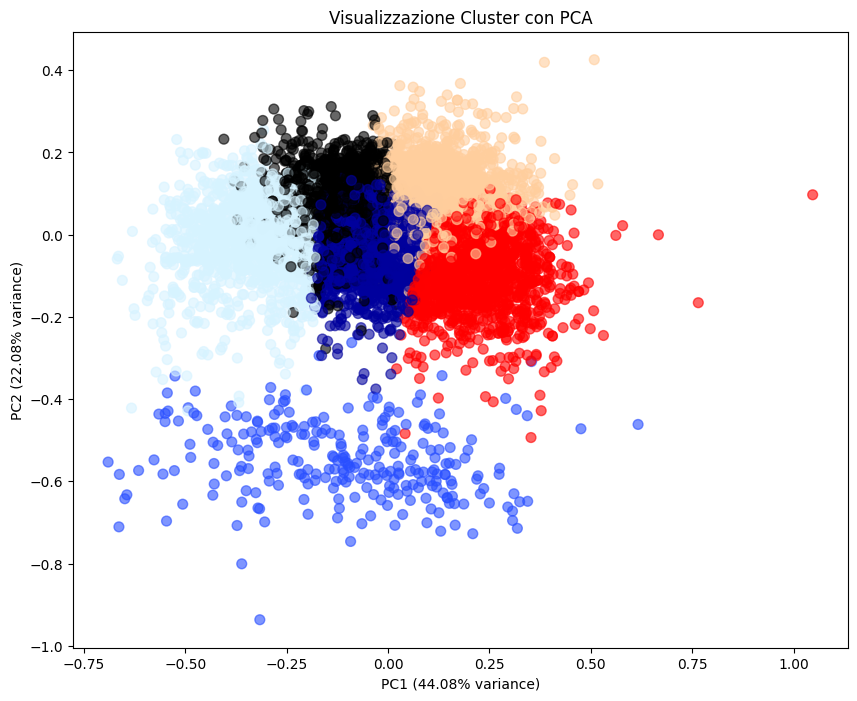

In [13]:
# Applico PCA per visualizzazione
pca = PCA(n_components=2)
array_pca = pca.fit_transform(json_norm.values)

labels = kmeans.labels_

# Plotto i cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(array_pca[:, 0], array_pca[:, 1], 
                      c=labels, cmap='flag', alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Visualizzazione Cluster con PCA')
plt.show()

In [14]:
# Calcola le medie delle feature per ogni cluster
json_norm['cluster'] = labels

# Statistiche per cluster
cluster_means = json_norm.groupby('cluster').mean()
print(cluster_means)

              bpm   rolloff      flux       rms  flatness  \
cluster                                                     
0        0.079230  0.231512  0.642966  0.432269  0.831169   
1        0.083454  0.154213  0.683750  0.460054  0.874222   
2        0.082340  0.173504  0.609812  0.179944  0.843711   
3        0.072662  0.206285  0.644473  0.306146  0.175150   
4        0.078760  0.193595  0.625307  0.333951  0.871026   
5        0.077036  0.176280  0.696052  0.322399  0.862851   

         spectral_complexity     pitch  loudness  
cluster                                           
0                   0.632910  0.512119  0.365566  
1                   0.463180  0.631546  0.401757  
2                   0.246026  0.537750  0.120631  
3                   0.417574  0.552394  0.243375  
4                   0.457988  0.508119  0.264124  
5                   0.346379  0.646478  0.257006  


In [15]:
mood_labels = {
    0: "Trap/Drill",
    1: "Club/Party Rap", 
    2: "Cloud Rap/Experimental",
    3: "Boom Bap/Classic Hip Hop",
    4: "Lo-Fi Hip Hop/Chill Rap",
    5: "Introspective Rap"
}

# Aggiungi le etichette al tuo DataFrame
json_norm['mood'] = json_norm['cluster'].map(mood_labels)

In [16]:
json_norm.head(30)

,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,cluster,mood
0,0.111087,0.335316,0.751828,0.287184,0.798114,0.420022,0.578804,0.218035,5,Introspective Rap
1,0.102315,0.391209,0.701737,0.324811,0.633842,0.475461,0.473875,0.261868,4,Lo-Fi Hip Hop/Chill Rap
2,0.108669,0.235930,0.716723,0.410355,0.757691,0.440626,0.622173,0.359485,1,Club/Party Rap
3,0.150745,0.133903,0.803682,0.316932,0.861217,0.233502,0.747457,0.250241,5,Introspective Rap
4,0.067669,0.196093,0.564480,0.380929,0.839546,0.599373,0.393699,0.309230,0,Trap/Drill
5,0.047250,0.134190,0.556754,0.375301,0.881316,0.376559,0.486644,0.308343,4,Lo-Fi Hip Hop/Chill Rap
6,0.102978,0.207033,0.631164,0.423219,0.841904,0.489302,0.528896,0.357039,4,Lo-Fi Hip Hop/Chill Rap
7,0.103170,0.269958,0.707182,0.414215,0.797103,0.596260,0.535195,0.350997,0,Trap/Drill
8,0.094604,0.284483,0.629349,0.413732,0.818662,0.669311,0.466157,0.342645,0,Trap/Drill
9,0.139982,0.192326,0.565725,0.346840,0.887155,0.493129,0.440252,0.275192,4,Lo-Fi Hip Hop/Chill Rap


In [17]:
json_finale = json.join(json_norm[['mood']], how='left')

In [18]:
json_finale.head()

,id,id_artist,title,featured_artists,primary_artist,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,year,month,day,n_sentences,n_tokens,char_per_tok,avg_token_per_clause,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,album_name,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,id_album,lyrics,streams@1month,yt_virality,original_id_bugged,mood
0,TR000001,ART04205421,​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,13,6,"['cazzo', 'cesso', 'coglioni', 'figa', 'merda'...","['bitch', 'fuck', 'porno', 'pussy']",2021.0,4.0,2.0,102.0,911.0,4.170455,8.133929,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,AL000001,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",186522,Trending,TR934808,Introspective Rap
1,TR000002,ART04205421,POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,9,12,"['cazzo', 'culo', 'frocio', 'puttana', 'sega',...","['escort', 'negro', 'sex', 'sexy', 'shit']",2020.0,3.0,6.0,56.0,675.0,4.280851,12.500000,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,AL000001,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",194313,Mainstream,TR760029,Lo-Fi Hip Hop/Chill Rap
2,TR000003,ART04205421,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,16,12,"['bastardo', 'cazzo', 'culo', 'merda', 'troia']","['bastardo', 'bitch', 'bitches', 'cock', 'fuck']",2021.0,2.0,19.0,88.0,758.0,4.075251,8.422222,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590,FOREVER AND EVER,2021-04-09,album,1.0,1.0,193544.0,1.0,39.0,AL000001,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",63750,Trending,TR916821,Club/Party Rap
3,TR000004,ART04205421,CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,8,3,"['cazzo', 'culo', 'fottere', 'merda', 'pompino...","['fuck', 'porno', 'shit']",2019.0,3.0,8.0,37.0,382.0,4.023881,6.701754,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067,OKAY OKAY 2,2025-05-16,single,1.0,2.0,169000.0,1.0,47.0,AL000002,Designer sui vestiti penso di essere un outlet...,41473,Emerging,TR480968,Introspective Rap
4,TR000005,ART04205421,LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,1,0,['cazzo'],[],2020.0,5.0,29.0,48.0,429.0,3.922857,8.411765,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407,FOREVER,2020-05-28,album,1.0,8.0,194779.0,1.0,41.0,AL000001,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",30553,Trending,TR585039,Trap/Drill


In [19]:
# Salva come array di oggetti JSON
json_finale.to_json('tracks_moods.json', 
                   orient='records',
                   force_ascii=False,
                   indent=2)

In [20]:
analisi = pd.read_json('tracks_moods.json')

In [21]:
analisi.head()

,id,id_artist,title,featured_artists,primary_artist,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,year,month,day,n_sentences,n_tokens,char_per_tok,avg_token_per_clause,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,album_name,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,id_album,lyrics,streams@1month,yt_virality,original_id_bugged,mood
0,TR000001,ART04205421,​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,13,6,"['cazzo', 'cesso', 'coglioni', 'figa', 'merda'...","['bitch', 'fuck', 'porno', 'pussy']",2021.0,4.0,2.0,102.0,911.0,4.170455,8.133929,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,AL000001,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",186522,Trending,TR934808,Introspective Rap
1,TR000002,ART04205421,POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,9,12,"['cazzo', 'culo', 'frocio', 'puttana', 'sega',...","['escort', 'negro', 'sex', 'sexy', 'shit']",2020.0,3.0,6.0,56.0,675.0,4.280851,12.500000,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,AL000001,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",194313,Mainstream,TR760029,Lo-Fi Hip Hop/Chill Rap
2,TR000003,ART04205421,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,16,12,"['bastardo', 'cazzo', 'culo', 'merda', 'troia']","['bastardo', 'bitch', 'bitches', 'cock', 'fuck']",2021.0,2.0,19.0,88.0,758.0,4.075251,8.422222,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590,FOREVER AND EVER,2021-04-09,album,1.0,1.0,193544.0,1.0,39.0,AL000001,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",63750,Trending,TR916821,Club/Party Rap
3,TR000004,ART04205421,CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,8,3,"['cazzo', 'culo', 'fottere', 'merda', 'pompino...","['fuck', 'porno', 'shit']",2019.0,3.0,8.0,37.0,382.0,4.023881,6.701754,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067,OKAY OKAY 2,2025-05-16,single,1.0,2.0,169000.0,1.0,47.0,AL000002,Designer sui vestiti penso di essere un outlet...,41473,Emerging,TR480968,Introspective Rap
4,TR000005,ART04205421,LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,1,0,['cazzo'],[],2020.0,5.0,29.0,48.0,429.0,3.922857,8.411765,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407,FOREVER,2020-05-28,album,1.0,8.0,194779.0,1.0,41.0,AL000001,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",30553,Trending,TR585039,Trap/Drill


In [22]:
# Visualizza tutte le 64 righe con mood nullo
righe_nulle = analisi[analisi['mood'].isna()]

print(f"Numero di righe senza mood: {len(righe_nulle)}")
print("\n" + "="*80 + "\n")

# Mostra tutte le 64 righe (non solo le prime 5)
pd.set_option('display.max_rows', None)  # Mostra tutte le righe
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.width', None)  # Nessun limite di larghezza
pd.set_option('display.max_colwidth', 50)  # Max 50 caratteri per colonna

print(righe_nulle[['id', 'title', 'primary_artist', 'bpm', 'rolloff', 'flux', 'rms', 'flatness', 'mood']])

Numero di righe senza mood: 0


Empty DataFrame
Columns: [id, title, primary_artist, bpm, rolloff, flux, rms, flatness, mood]
Index: []
